<a href="https://colab.research.google.com/github/JraHike76/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/Jay_Adamo_Model_Interpretation_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [97]:
# I will use my project dataset
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/JraHike76/Build-Week-Unit-2/master/Seattle_Air%20BnB_Reviews_2016.csv')

!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

In [98]:
# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [99]:
# looking for something binary, yes or no, good or not....
# engineer feature 'highly_recommended' based on percents from 'review_scores_rating'

df['highly_recommended'] = df['review_scores_rating'] >= 96

df['highly_recommended'].describe()

count      3818
unique        2
top       False
freq       2055
Name: highly_recommended, dtype: object

In [100]:
# Drop all nulls from new subset

df = df.dropna(subset = ['review_scores_rating'])

df['highly_recommended'].describe()

count     3171
unique       2
top       True
freq      1763
Name: highly_recommended, dtype: object

In [101]:
df = df.drop(columns = ['review_scores_rating', 'neighbourhood_group_cleansed', 'id', 'name','location', 'host_is_superhost', 'street','longitude', 'latitude', 'last_scraped'])
df.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,minimum_nights,cancellation_policy,highly_recommended
0,Apartment,Entire home/apt,4,1.0,1.0,1.0,NaN,$85.00,1,moderate,False
1,Apartment,Entire home/apt,4,1.0,1.0,1.0,NaN,$150.00,2,strict,True
2,House,Entire home/apt,11,4.5,5.0,7.0,NaN,$975.00,4,strict,True
4,House,Entire home/apt,6,2.0,3.0,3.0,NaN,$450.00,1,strict,False
5,House,Private room,2,1.0,1.0,1.0,NaN,$120.00,1,strict,False


In [102]:
# dealing with nans

df.isnull().sum()

property_type             0
room_type                 0
accommodates              0
bathrooms                12
bedrooms                  6
beds                      0
square_feet            3080
price                     0
minimum_nights            0
cancellation_policy       0
highly_recommended        0
dtype: int64

In [103]:
df['bathrooms'] = df['bathrooms'].fillna(0)
df['square_feet'] = df['square_feet'].fillna(0)

In [104]:
# train/val/test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = .20, random_state = 42)

train, val = train_test_split(train, test_size = .20, random_state = 42)

train.shape, val.shape, test.shape

((2028, 11), (508, 11), (635, 11))

In [105]:
# Assign to X, y
target = 'highly_recommended'
features = df.columns.drop('highly_recommended')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [106]:
y_train.head()

2909    False
3266    False
252      True
3008     True
468      True
Name: highly_recommended, dtype: bool

In [107]:
# Fit gradient Boosting Model
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 -0.011389602007043198


In [108]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [109]:
features


Index(['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'minimum_nights',
       'cancellation_policy'],
      dtype='object')

In [110]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'accommodates'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd227c88518>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd228c00828>})

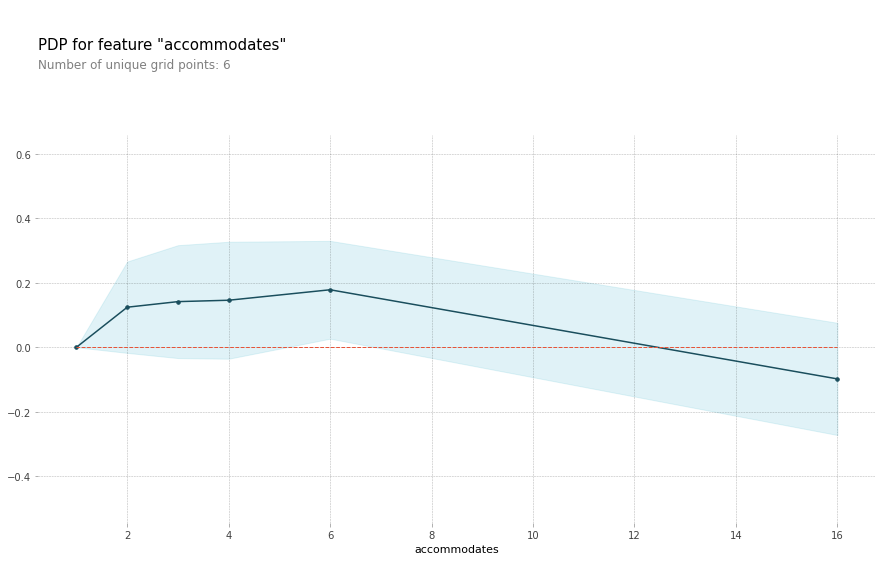

In [111]:
pdp_plot(isolated, feature_name=feature)

In [112]:
# Shapley

In [113]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0133s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0325s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


ValueError: ignored

In [ ]:
# What was the actual rent for this apartment?
y_test.iloc[[0]]

In [ ]:
# What does the model predict for this apartment?
model.predict(row)

In [115]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.57722	validation_1-auc:0.562607
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.577158	validation_1-auc:0.563372
[2]	validation_0-auc:0.577567	validation_1-auc:0.564223
[3]	validation_0-auc:0.595212	validation_1-auc:0.576198
[4]	validation_0-auc:0.599965	validation_1-auc:0.58118
[5]	validation_0-auc:0.612247	validation_1-auc:0.572177
[6]	validation_0-auc:0.623329	validation_1-auc:0.572658
[7]	validation_0-auc:0.624934	validation_1-auc:0.559431
[8]	validation_0-auc:0.627237	validation_1-auc:0.565382
[9]	validation_0-auc:0.631907	validation_1-auc:0.561259
[10]	validation_0-auc:0.634501	validation_1-auc:0.565437
[11]	validation_0-auc:0.637823	validation_1-auc:0.560905
[12]	validation_0-auc:0.637675	validation_1-auc:0.558382
[13]	validation_0-auc:0.639217	validation_1-auc:0.559628
[14]	validation_0-auc:0.642483	validation_1-auc:0.557625


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [116]:
# THIS CELL ISN'T ABOUT THE NEW OBJECTIVES FOR TODAY
# BUT IT IS IMPORTANT FOR YOUR SPRINT CHALLENGE

from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.5703825136612022


In [117]:
# STUDY/PRACTICE THIS CELL FOR THE SPRINT CHALLENGE
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

ValueError: ignored